# Surprise Removal
## John R. Lawson, December 2020
#### (Supporting material for MDPI Atmosphere paper)
##### Coauthors: Corey K. Potvin and Kenric Nelson. Code by JRL. 
##### Work supported by CIMMS/NSSL, Norman, Oklahoma, USA


Outline:

* Write class (L63) to 
    1. Generate Lorenz time series
    2. Discretise it in time, space, thresh, etc
    3. Test whether IG is sensitive to:
        a. intermittency (rho parameter)
        b. ICs (error)
        c. drift (model error)
        d. window length  
        e. percentile
    4. Plot suite of visualisations for data    
* Write class (InfoGain) to
    1. Verify data with cross-entropy
        a. Decompose into REL, DSC, UNC
        b. Other decomps in Wilks 
    2. Verify data with BS
    3. (Stretch goal: extend to continuous & ranked)
    4. Plot suite of visualisations for verification
* Write class (utils) to
    1. Run stuff for this paper
    2. ?
    
Links with Wilks textbook:

* IGN v BS, or CRPS v CRIGN, for different regimes etc
* The SS isn't proper. Is this a big deal?
* Visualisation suite

Ultimately:
* Show IG is better for rare events
* Kernel dressing?
* Interpretation of ignorance removal
* Probably show that BS and IGN give different "winners" when the distribution of forecasts becomes (multimodal?).


## The problem
There are two issues with EFSs:

1. They are often underdispersive, and do not capture low-probability events. This is remedied by increasing quantisation in probability space, $\Delta p$, by increasing ensemble membership $N_e$.
2. At the thunderstorm scale, grid resolution of $\Delta x = \textrm{3 km}$ is insuffient to resolve critical processes for e.g., tornadogenesis. This is addressed by decreasing $\Delta x$.

We have an increase in computer resources $\delta \varsigma > 0$ to spend. Increasing ensemble membership costs $\varsigma (\delta \Delta p)$; increasing horizonal resolution is $\frac{\Delta x_{0}}{\Delta x_{1}}^{3}$, where the cubed power comprises the required increase in calculations in the x- and y-dimensions, plus the required time-step decrease in the CFL criterio, as $\Delta t \sim 5\Delta x$. This ignores increases in bottleneck latency and vertical resolution. (And without kernel dressing, a finer resolution demands a larger $N_e$ due to the curse of dimensionality.)

Further, our evaluation schemes that are based on Mean Square Error (e.g., Fractions Skill Score, Briar Score) are approximations that insufficiently reward non-zero probabilities of rare events. It is time to boil down our problem to __information transfer__.

## Optimising $\Delta x$ versus $\Delta p$
------------------------------------------------

Consider two end-users: an ice-cream vendor (Igor) and a crane operator (Cath). Both Igor and Cath are worried about the risk of a severe thunderstorm $\xi$. Both Igor and Cath check the forecast, where their expected probability of the hazard is $\mathrm{E}(\xi)$ is 0.05. Igor and Cath incur the following costs $C$ (anticipated outgoings) and losses $L$ (surprising outgoings):

|  $\dotsb$     | Operation    | Mitigation |
| ------------- | ------------ | -----------|
| Hazard occurs | $L$          | $C$        |
| Hazard does not occur | $\dotsb$ | $C$    |

Avoiding action and losing profit are the components of $C$, whereas $L$ is the unexpected outlay due to damage, liability, etc. **At what probability should Igor and Cath take avoiding action?** We also seek:

* What risk threshold $p_\textrm{crit}$ should Igor and Cath implement their mitigation plans?
* How does this change with the rarity of the event?
* How does this change with the ratio of cost and loss $\frac{C}{L}$ between Igor and Cath?
* Should we spend computer resources of more ensemble members (a finer resolution $\Delta p$ in probability space) or a higher resolution forecast (lower $\Delta x$)? We attempt to bound the minimum information gain required to optimise the end-user's profit. 
* Can the same optimisation help both customers in all regimes?

The following computing costs apply:
 
$$
\varsigma(M_1) = \varsigma(e_0) \big( \frac{\Delta x_1}{\Delta x_0} \big )^3 \delta N_e + B
$$

Above, (X) says that one computing unit is defined as the cost of one original-model ($\mathbb{M_0}$) ensemble member (at the coarse resolution); (X) states that a reduction in $\delta x$ costs (in km). Could state $N_e$ in terms of dp instead. 

We need a measure of forecast skill in terms of remaining uncertainty (or ingorance) after the forecast is obtained. We will use cross-entropy (rather than Briar score; see later), where zero is a perfect score:

WHAT IS N, BE SPECIFIC

$$
H_\times(o,f) = -\frac{1}{N} \sum^{N_t}_{t=1} \sum^{n}_{i=1} o_{t,i} \log_2 f_{t,i}
$$

which can be decomposed as 

$$
H_\times(o,f) = \underbrace{ \frac{1}{N_t} \sum^{N_k}_{k=1} n_k D_\textrm{KL} (\bar{o}_k \| f_k) }_\textrm{Reliability (REL)} - 
\underbrace{ \frac{1}{N_t} \sum^{N_k}_{k=1} n_k D_\textrm{KL} (\bar{o}_k \| \bar{o}) }_\textrm{Discrimination (DSC)} + 
\underbrace{ \frac{1}{N_t} \sum^{N_t}_{t=1} D_\textrm{KL} (o_t \| \bar{o}) }_\textrm{Uncertainty (UNC)} + 
\underbrace{ \frac{1}{N_t} \sum^{N_t}_{t=1} H(o_t) }_\textrm{Obs. Uncertainty} \\
\forall t \in \{ 0,1,...,N_t \} \cap k \in \{ \underline{\rho},\frac{1}{N_e},\frac{2}{N_e},...,\frac{N_e-1}{N_e},\bar{\rho} \}
$$

where $D_{\textrm{KL}}$ is the Kullback-Liebler divergence, denoting the uncertainty or surprise (entropy) remaining after a forecast is issued, upon verification:

$$
D_{KL}(x\|y) = \sum^{n}_{i=1} x_i \log_2 \frac{x_i}{y_i}
$$

and average surprise is represented by Shannon entropy:

$$
H(x) = -\sum^{n}_{i=1} x_i \log_2 x_i
$$

Probabilities are bounded to $[ \underline{\rho},\bar{\rho} ]$ to avoid divergence to infinity, but also to avoid full confidence in the face of underdispersion (overfitting). Above, $f$ and $o$ are vectors.


A skill score is formed as

$$
\textrm{SS} = \frac{\textrm{RELDSC}}{\textrm{UNC}} +- \frac{\textrm{RELDSC}}{\textrm{UNC}}
$$

(Might we want a measure of how severe the largest surprise is? How long the tail is?) The normalised components are useful for comparing the useful and detrimental information from the NWP output.

With grid spacing, there is the curse of dimensionality. That doesn't exist for probability as long as spread is good enough, if kernel dressing is used. If user's threshold is 20%, they are less sensitive to reliability error than a user tolerating only 10% risk. (Or is it only for rarity of event?) For rarity of event, less likely to be captured by the ensemble member.

(EFS members merely attempt to resolve basins of attraction. Want members to be around the cusp (discrim?) but also sample the outer regions well enough to pick up low-amplitude signals, rare events (reliability?).

Entropy is like risk of trying to remove the big-reward (low frequency) events (x-axis is surprise, y is prob density). one continuous, smooth cusp between two basins of attraction (like Lawson 2019?) is low-surprise events divided by a highly entropic  entropy (0.5 and 0.5)

Compute value as tolerance in units of missed-hit frequency,  where perhaps if DISCRIM is indeed a problem (overconfident)

Compare to BS.

In [1]:
import pdb
import matplotlib as M
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import sys
import os
import copy
import pickle
%matplotlib inline
%pdb off
import multiprocessing
import random

#import matplotlib.font_manager
#print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))
M.rcParams['font.family'] = 'sans-serif'
M.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
np.set_printoptions(precision=3,suppress=True)
pd.set_option("display.precision",3)
pd.set_option("display.float_format",'{:.3f}'.format)
# np.random.seed(383838)
ncpus = 4

Automatic pdb calling has been turned OFF


In [2]:
class BrierScore:
    def __init__(self,f,o,fk=None):
        """ Initialise verification.
        
        Args:
        f   : 1-D prob forecasts [0,1]*
        o   : 1-D obs forecast [0,1], may or may not include obs uncertainty
        fk  : 1-D array of probability levels. If None, compute automatically
        
        * = should be bounded to avoid divergence to match IG verification
        
        TODO:
        * Parallelise?
        """
        self.forecasts = f
        self.observations = o 
        
    def compute_BS(self,):
        return 0
    
    def compute_BSS(self,):
        return 0
        

We deploy Lorenz's 1963 three-variable model of convection (L63) in an intermittent regime (i.e., extreme events come in infrequent bursts). We will create two ensembles: one with more accurate initial conditions than the other to simulate a "good" and "bad" model. We will also consider two different levels of exceedence in the L63 z-variable time series to represent an event occurring. The higher percentile chosen represents the rarer event. 

In [3]:
# double approx help from github user kendixon

class L63:
    def __init__(self,x0,y0,z0,rho,
                 sigma=10.0,beta=2.667,dt=1e-3):
        """Chop off spin-up time?
        
        TODO:
            * Remove spin-up time (transients)
            * Add perturbations (with random seed allowed as arg)
        the paper values use the intermittent regime
        
        rho
        166.08 is intermittent
        166.1 is the (more intermittent) variation
        28.0 is the lorenz default
        """
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt =dt
        self.t = 0.0

        # The data array in x,y,z. Time appended in axis=3
        self.output = np.zeros((3,1))
        self.output[:,0] = [x0,y0,z0]
        # self.

    def dxdt(self,x,y):
        return self.sigma * (y-x)
    def dydt(self,x,y,z):
        return x * (self.rho - z) - y
    def dzdt(self,x,y,z):
        return (x*y) - (self.beta * z)
    
    def double_approx(self,x,y,z):
        dx1 = self.dxdt(x,y)*self.dt + x
        dy1 = self.dydt(x,y,z)*self.dt + y
        dz1 = self.dzdt(x,y,z)*self.dt + z
        
        dx2 = self.dxdt(dx1,dy1)
        dy2 = self.dydt(dx1,dy1,dz1)
        dz2 = self.dzdt(dx1,dy1,dz1)
        
        x2 = self.dt*(0.5*dx1 + 0.5*dx2) + x
        y2 = self.dt*(0.5*dy1 + 0.5*dy2) + y
        z2 = self.dt*(0.5*dz1 + 0.5*dz2) + z
        
        return x2,y2,z2
        
    def integrate_once(self,):
        """
        Args:
            t0    : Initial time
            y0    : Intiial state
        """
        x = self.output[0,-1]
        y = self.output[1,-1]
        z = self.output[2,-1]
        # print(x,y,z)
        ret = self.double_approx(x,y,z)
        # print(ret)
        new_time = np.expand_dims(np.array(ret),axis=1)
        return new_time
        
    def integrate(self,n,clip=None):
        # Time 0 is already done
        for n in range(n-1):
            next_data = self.integrate_once()
            # print(self.output.shape,next_data.shape)
            self.output = np.concatenate((self.output,next_data),axis=1)
            # print(self.output)
        #print(self.output)
        if clip is not None:
            self.output = self.output[:,clip:]
            # cut_nt = nt - clip
        return 
    
    def get_z(self,):
        return self.output[2,:]

    def get_exceedence_ts(self,pc,vrbl='z'):
        data = self.get_z()
        exceed = self.get_pc_exceed(data,pc)
        return exceed
    
    @staticmethod
    def get_pc_exceed(ts,pc):
        return ts > np.percentile(ts,pc)
    
    @staticmethod
    def do_windowing(ts,wsize):
        """
        Args:
        ts    : time series of raw data.
        wsize : epoch window size in time steps
        """
        nt = ts.size
        epochs = np.zeros(int(nt/wsize)+1).astype(bool)
        widx = np.arange(0,nt,wsize)
        windows = np.zeros_like(ts).astype(bool)
        epoch_idx = np.arange(int(wsize/2),nt,wsize)
        for nc,cidx in enumerate(widx):
            idx0 = int(nc*wsize)
            idx1 = int(idx0 + wsize)
            this_window = ts[idx0:idx1]
            epochs[nc] = True in this_window
            windows[idx0:idx1] = bool(epochs[nc])    
        return windows        
    
    @classmethod
    def mask_and_window(cls,arr,pc,wsize):
        if arr.ndim == 1:
            nt = arr.size
            arr = arr.reshape(1,nt)
        pc_arr = cls.get_pc_exceed(arr,pc)
        window_ts = np.zeros_like(pc_arr)
        for ne in range(pc_arr.shape[0]):
            window_ts[ne,:] = cls.do_windowing(pc_arr[ne,:],wsize)
        # window_ts = cls.do_windowing(pc_ts,wsize)
        return window_ts


We use the z-component (in L63, this represents rising motion in convective cells) as our time series. We convert to a binary forecast by identifying where the time series exceeds the given percentile. We then quantise in time to both introduce tolerance and mimic EFS real-world output.

A cool thought: the rarer the event, the more that average surprise (shannon entropy) is distributed at extreme bipoles. Hence some of the apparent contradiction that uncertainty around a common event (e.g., cloudy) that has most entropy. 

In [4]:
def generate_z_ts(x0,y0,z0,rho,nt_all,cutoff):
    lorenz = L63(x0,y0,z0,rho=rho)
    lorenz.integrate(nt_all,clip=cutoff)
    return lorenz.get_z()

def make_itr(tweak_max,Ne):
    tweaks = np.random.uniform(0,tweak_max,Ne)
    for ne, tweak in enumerate(tweaks):
        yield x0+tweak, y0+tweak, z0+tweak, rho

def do_run(i):
    x0,y0,z0,rho = i
    lorenz = L63(x0,y0,z0,rho)
    lorenz.integrate(nt_all,clip=cutoff)
    return lorenz.get_z()

def generate_ensemble(x0,y0,z0,Ne,rho,tweak_max,nt_all,cutoff):
    itr = make_itr(tweak_max,Ne)
    if ncpus == 1:
        ensemble = np.zeros([Ne,nt_all-cutoff])
        for n,i in enumerate(itr):
            print(f"Computing member {ne}")
            ensemble[n,:] = do_run(i)
    else:
        with multiprocessing.Pool(ncpus) as pool:
            returns = pool.map(do_run,itr)
        ensemble = np.array(returns)
    return ensemble
                      

In [5]:
# Want truth to be window size 100?
# Then test with 200,500 window size

# Catalogue of runs
# first idx is obs, rest is fcst 


# Do numerous "days" for a longer experiment?

# Parallelisation?
# Initial conditions
x0 = 1.0
y0 = 1.0
z0 = 1.0

# Total integration steps
nt_all = 30000

# Spin-up period to be removed
cutoff = 15000

# Window size for scale-aware
# Can do later when computing scores
# wsize = 500 

# Number of ensemble members
# Can subset later
Ne = 200

# Number of time steps in raw data after spin-up is cut off
nt = nt_all - cutoff

# Measure of intermittency
rho_list = [166.08,166.09,166.1]
# percentiles for thresholding
pc_list = [93.5,95.5,97.5,98.5,99.5,99.9]
# IC perturbations for ensembles
tweak_max_list = [1e-8,1e-7,1e-6,1e-5] 

# wsize = 100 will be minimum (i.e. truth)
wsize_list = [50,100,200,300,400,500]

# Raw
OBS = {r:{} for r in rho_list}
FCST = {r:{t:{} for t in tweak_max_list} for r in rho_list}

# Windowed and percentile-masked
OBS_PW = {r:{pc:{w:0 for w in wsize_list} for pc in pc_list} 
                for r in rho_list}
FCST_PW = {r:{t:{pc:{w:0 for w in wsize_list} for pc in pc_list}
                for t in tweak_max_list} for r in rho_list}
    
for rho, tweak_max in itertools.product(rho_list,tweak_max_list):
    obs_file = f'data/obs_{int(rho*1000)}.npy'
    fcst_file = f'data/fcst_{int(rho*1000)}_{int(tweak_max*1e8)}.npy'

    # Create observation data (only once per IC perturbation value (tweak_max))
    if tweak_max == tweak_max_list[0]:
        if os.path.exists(obs_file):
            OBS[rho] = np.load(obs_file)
        else:
            obs = generate_z_ts(x0,y0,z0,rho,nt_all,cutoff)
            OBS[rho] = obs.reshape(1,obs.size)
            np.save(arr=obs,file=obs_file)

        for pc, wsize in itertools.product(pc_list,wsize_list):
            ts_pw = L63.mask_and_window(OBS[rho],pc,wsize)
            OBS_PW[rho][pc][wsize] = ts_pw
    
    # Create forecast data
    if os.path.exists(fcst_file):
            FCST[rho][tweak_max] = np.load(fcst_file)
    else:
        if __name__ == "__main__":
            fcst = generate_ensemble(x0,y0,z0,Ne,rho,tweak_max,nt_all,cutoff)
        FCST[rho][tweak_max] = fcst
        np.save(arr=fcst,file=fcst_file)
            
    for pc, wsize in itertools.product(pc_list,wsize_list):
        ts_pw = L63.mask_and_window(FCST[rho][tweak_max],pc,wsize)
        FCST_PW[rho][tweak_max][pc][wsize] = ts_pw
        
# [Ne x Nt]

In [6]:
def plot_example(raw_obs,obs_pw,raw_fcst,fcst_pw,pc,wsize,title):
    # Plotting
    fig,axes = plt.subplots(figsize=(8,7),ncols=1,nrows=4)

    nt = raw_obs.size
    raw_xlocs = np.arange(nt)
    window_locs = np.arange(wsize,nt+wsize,wsize)
    x_lines = np.arange(0,nt+wsize,wsize)

    axes.flat[0].plot(raw_xlocs,raw_obs,color='b')
    axes.flat[0].set_title(title)
    axes.flat[0].hlines(y=np.percentile(raw_obs,pc),
                           xmin=0,xmax=nt,color='k')

    # axes.flat[1].fill(raw_xlocs,obs_pw,color='m')
    # axes.flat[1].plot(raw_xlocs,obs_pw,color='m')
    axes.flat[1].fill_between(x=window_locs,y1=obs_pw[::wsize],
                                y2=0,step='pre',color='b')
    axes.flat[1].vlines(x=x_lines,ymin=0,ymax=1,color='k')
    
    axes.flat[2].plot(raw_xlocs,raw_fcst,color='r')
    axes.flat[2].hlines(y=np.percentile(raw_fcst,pc),
                           xmin=0,xmax=nt,color='k')
        
    axes.flat[3].fill_between(x=window_locs,y1=fcst_pw[::wsize],
                                y2=0,step='pre',color='r')

    axes.flat[3].vlines(x=x_lines,ymin=0,ymax=1,color='k')
    # axes.flat[3].fill(raw_xlocs,fcst_pw,color='k')   
    
    # make prettier
    for n in (1,3):
        axes.flat[n].hlines(y=(0,1),xmin=0,xmax=nt,color='k')
        
    return

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


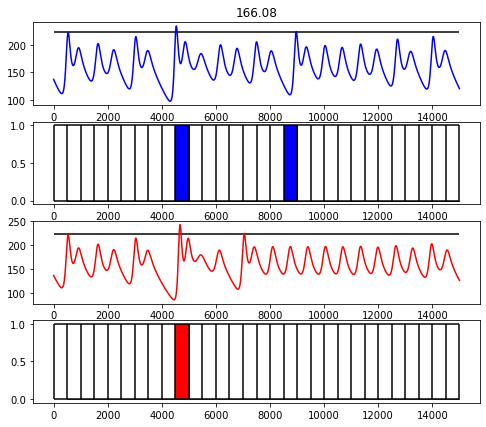

In [7]:
rho = 166.08
pc = 99.5
wsize = 500
tweak_max = 1e-7
raw_fcst = FCST[rho][tweak_max][0,:]
fcst_pw = FCST_PW[rho][tweak_max][pc][wsize][0,:]

# Weirdness with dimensions
raw_obs = OBS[rho]
if raw_obs.ndim == 2:
    raw_obs = raw_obs[0,:]
obs_pw = OBS_PW[rho][pc][wsize][0,:]

plot_example(raw_obs,obs_pw,raw_fcst,fcst_pw,
             pc,wsize,f"{rho}")

(15000,)


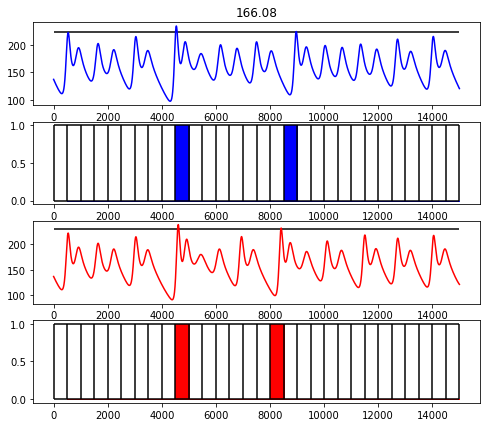

In [8]:
print(OBS[rho].shape)

raw_fcst = FCST[rho][tweak_max][1,:]
fcst_pw = FCST_PW[rho][tweak_max][pc][wsize][1,:]

plot_example(raw_obs,obs_pw,raw_fcst,fcst_pw,
             pc,wsize,f"{rho}")

In [27]:
class InfoGain:
    """ For computing and visualising skill scores for a probabilistic forecast.
    Currently for two categories (binary) only. 
    """
    def __init__(self,f,o,fk=None):
        """ Initialise the suite.
        
        Args:
        f   : 1-D prob forecasts [0,1]*
        o   : 1-D obs forecast [0,1], may or may not include obs uncertainty
        fk  : 1-D array of probability levels. If None, compute automatically
        
        * = should be bounded to avoid divergence to infinity
        
        TODO:
        * logbase needs un-hardcoding
        * Parallelise?
        """
        self.f = f
        self.o = o
        self.logbase = 2 
        
        if fk == None:
            self.fk = np.unique(self.f) 
        else:
            self.fk = fk 
        
    @staticmethod
    def compute_DKL(x,y):
        """ Kullback-Liebler Divergence

        Args:
        x   : 1-D (e.g., observations)
        y   : 1-D (e.g., forecasts)

        """
        with np.errstate(divide='ignore',invalid='ignore'):
            term1 = ((1-x) * np.log2((1-x)/(1-y)))
            term2 = (x * np.log2(x/y))
        
        term1[x==1] = 0
        term2[x==0] = 0
        
        DKL_all = term1 + term2
        DKL = np.mean(DKL_all)
        return DKL, DKL_all
    
    def compute_DS(self):
        return(self.compute_DKL(self.o,self.f))
    
    def compute_DSS(self):
        UNC = self.compute_UNC()
        DS = self.compute_DS()[0]
        DSS = (DS-UNC)/(0-UNC)
        # pdb.set_trace()
        return DSS
    
    @staticmethod
    def compute_entropy(x):
        """ Average surprise. A series of surprise
        values are returned if return_all is True.
        
        Is this right? Surprise v UNC?
        
        """
        H_all = x * np.log2(x)
        H = np.sum(H_all)
        return H, H_all
    
    def compute_XES(self):
        """ Cross-entropy score.

        Args:

        """
        XES = self.compute_DKL(self.o,self.f)[0] + self.compute_entropy(self.o)[0]
        return XES 

    def compute_DSC(self):
        """ Compute discrimination component of DKL.

        Args:

        """
        # p_o  : frequency of observation for this k
        dsc = np.zeros_like(self.fk)
        for nk,k in enumerate(self.fk):
            ok = o[f==k]
            ok_bar = np.mean(ok)
            o_bar = np.mean(o)
            dsc[nk] = ok.size * self.compute_DKL(ok_bar,o_bar)[0]
        DSC = np.sum(dsc)/o.size
        return DSC
    
    def compute_REL(self):
        """ Compute reliability.
        """
        REL_all = 0
        REL = 0
        return REL, REL_all
        
    def compute_UNC(self):
        """ Compute uncertainty component of the forecast.
        """
        p_o = np.mean(self.o)
        # with np.errstate(divide='ignore',invalid='ignore'):
        term1 = -p_o*np.log2(p_o)
        term2 = (1-p_o)*np.log2(1-p_o)
        UNC = term1 - term2
        return UNC 
    
    @staticmethod
    def bound(x,thresh=None,Ne=None):
        if thresh is None:
            thresh = 1/(3*Ne)
        x[x<thresh] = thresh
        x[x>(1-thresh)] = 1-thresh
        return x 
    
    def count_bin_size(x,fk):
        """From Wilks: need to bin fcst probs, setting the middle of
        the bin as the value...

        """
        bin_counts,bin_edges = np.histogram(x,bins=fk)
        return bin_counts

    def quantise(x,fk):
        # I think the index is not right, need to look at bin edges?
        quant_probs = np.digitize(x,fk)
        # pdb.set_trace()
        f = [fk[q-1] for q in quant_probs]
        return f


In [28]:
def subsample(ensemble,Ne):
    mems = random.sample(range(200),Ne)
    return ensemble[mems,:]


col_names = ['rho','tweak_max','pc','wsize','Ne','DS']
scores = pd.DataFrame(columns=col_names)
Ne_list = [5,10,20,30,40,50,100,150,200]
# Verification
for rho, tweak_max, pc, wsize, Ne in itertools.product(
        rho_list, tweak_max_list, pc_list, wsize_list, Ne_list):
    
    # Randomly select members
    raw_f = FCST_PW[rho][tweak_max][pc][wsize][:,::wsize]
    raw_p = subsample(raw_f,Ne)
    probs = InfoGain.bound(np.mean(raw_p,axis=0),Ne=Ne)
    obs = OBS_PW[rho][pc][wsize][0,::wsize].astype(int)
    IG = InfoGain(f=probs,o=obs)
    # DS, DS_all = IG.compute_DS()
    DS = IG.compute_DSS()
    # pd.DataFrame({'f':probs,'o':obs,'DS_t':DS_all}).head(10)
    scores = scores.append({'rho':rho,'tweak_max':tweak_max*1e8,
                          'pc':pc,'wsize':wsize,'Ne':Ne,'DS':DS},
                            ignore_index=True)
    
scores['wsize'] = scores['wsize'].astype('int16')
scores['tweak_max'] = scores['tweak_max'].astype('int16')
scores['Ne'] = scores['Ne'].astype('int16')
display(scores)

,rho,tweak_max,pc,wsize,Ne,DS
0,166.080,1,93.500,50,5,0.147
1,166.080,1,93.500,50,10,0.429
2,166.080,1,93.500,50,20,0.588
3,166.080,1,93.500,50,30,0.515
4,166.080,1,93.500,50,40,0.568
...,...,...,...,...,...,...
4531,166.100,1000,99.900,1000,40,-0.419
4532,166.100,1000,99.900,1000,50,0.018
4533,166.100,1000,99.900,1000,100,-0.071
4534,166.100,1000,99.900,1000,150,-0.008


In [29]:
def visualise_scores(scores,diag):
    cl = copy.copy(col_names)
    cl.remove(diag)
    diag_vals = scores[diag].unique()
    data = np.zeros([len(diag_vals),len(rho_list)])
    for ndv,dv in enumerate(diag_vals):
        for nrho, rho in enumerate(rho_list):
            sub_df = scores[(scores[diag]==dv) & (scores['rho']==rho)]
            data[ndv,nrho] = sub_df['DS'].mean() 
    
    fig,ax = plt.subplots(1,figsize=(7,7))
    x = np.arange(len(diag_vals))
    ax.bar(x-0.2,data[:,0],width=0.1,color='r',align='center',label=rho_list[0])
    ax.bar(x-0.0,data[:,1],width=0.1,color='g',align='center',label=rho_list[1])
    ax.bar(x+0.2,data[:,2],width=0.1,color='b',align='center',label=rho_list[2])
    
    ax.plot(x-0.2,data[:,0],color='r')
    ax.plot(x,data[:,1],color='g')
    ax.plot(x+0.2,data[:,2],color='b')
    
    ax.hlines(y=0,xmin=0,xmax=x[-1],color='k')    
    ax.set_xticks(x)
    ax.set_ylabel("Entropy (bits)")
    ax.set_xticklabels(diag_vals)
    ax.legend(facecolor='lightblue')
    # pdb.set_trace()
    


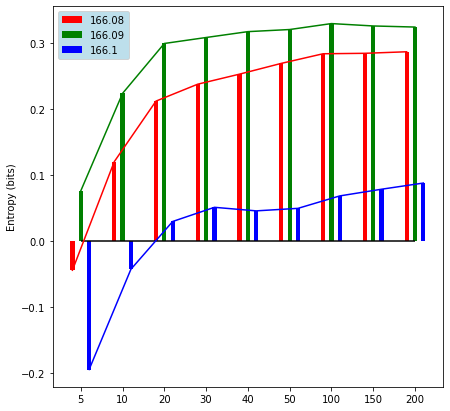

In [30]:
visualise_scores(scores,"Ne")

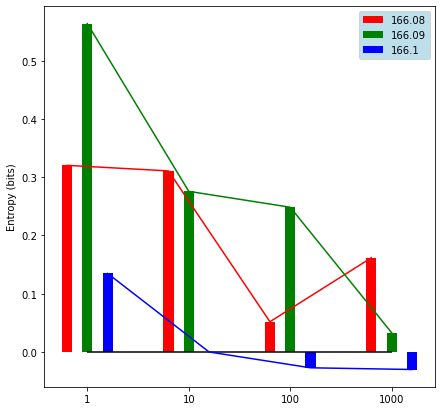

In [31]:
visualise_scores(scores,"tweak_max")

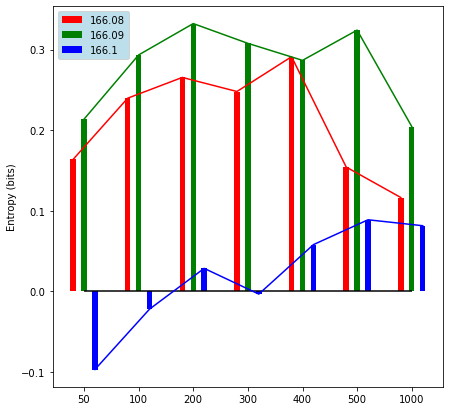

In [32]:
visualise_scores(scores,"wsize")

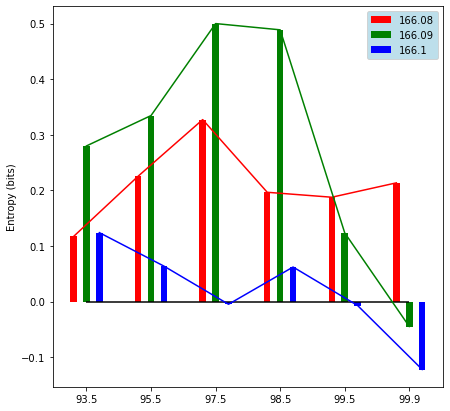

In [33]:
visualise_scores(scores,"pc")

### Kolmogorov-Sinai Entropy
We can now estimate the information provided by the EFS. But what is the prior uncertainty of the atmosphere? We can measure this in terms of __inforamtion loss per unit time__ for a model $\mathcal{M}$ with Kolmogorov-Sinai Entropy $H_{KS}$:

$$ H_{KS}(\mathcal{M}) =  \tau^{-1}\sum^{N_r}_{r=0} p_r \log_2 {p_r}^{-1} $$

where

$$ p_r = \prod^{{N_\alpha}}_{\alpha=0} p_{\alpha} $$

Above, $p_r$ represents the transition probabilies for each route along the decision tree (schematic of decision trees).

As $N_\alpha$ increases, there is more chance of encounting a rare event; as a rare event is exponentially rewarded, the $H_{\times}$ penalty is "bursty" also. Hence we estimate the limiting value by computing $H_{KS}$ over 4--20 epochs (output times; in contrast to real-world time $\tau$). As we do not have access to the atmosphere's rate of information loss, this is estimated from a prior EFS. Of course, this is not ideal due to cyclical logic, but we assume a perfect model providing prior probabilies. (This could stand for a 36-hour forecast such as HREF).

In [34]:
def get_TPs(N_epoch,ensemble,debug=False):
    """
    debug : 0 is off, 1 is some, 2 is all, 3 is pauses
    """
    N_routes = 2**N_epoch
    TPs = np.zeros([N_epoch,N_routes],dtype=float)

    # epoch 0: 
    epoch_data = ensemble[:,0].astype(bool)
    e0_true_idx = np.flatnonzero(epoch_data)
    e0_false_idx = np.flatnonzero(~epoch_data)

    # node 0:
    # Save which members were in which set
    nodeidx = {e:{False:[],True:[]} for e in range(N_epoch)}
    # Create lists of lists: [[idx_node0],[idx_node1],etc...]
    nodeidx[0][False].append(e0_false_idx)
    nodeidx[0][True].append(e0_true_idx)

    # transition 0:
    hlf = int(N_routes/2)
    TPs[0,:hlf] = e0_false_idx.size/Ne
    TPs[0,hlf:] = e0_true_idx.size/Ne

    print("+"*9,f"Computing K-S Entropy for {N_epoch}"
            f" epochs, for {Ne} members.")

    # Now loop over epochs to generate TPs
    for epoch in range(1,N_epoch):
        if debug==1:
            print(f"\n >>>>>>>>> For epoch {epoch}:")

        # Number of nodes
        nnodes = int((2**(epoch+1))/2)
        nodes = np.arange(nnodes,dtype=int)

        # Number of True/False groups (2x node)
        nsets = int(2**(epoch+1))
        # Indices to put for each node 
        sets = np.array([((n*2),(n*2)+1,(n*2)+2)
                       for n in nodes]).astype(int)

        # Indices for placing TPs in array
        tp_idx = np.linspace(0,N_routes,num=nsets+1,dtype=int)

        # node 0, 1, 2 etc...
        for node,_sets in zip(nodes,sets):
            if debug: print("Node:",node)
            prev_node = int(np.floor(node/2))
            # Get members that were true and false in the last epoch
            if node%2 == 0:
                mems = nodeidx[epoch-1][False][prev_node]
            else:
                mems = nodeidx[epoch-1][True][prev_node] # These 0 idx needs to be a prev node?
            if debug: print("Node members:",mems)

            # Get probability for each group moving to true/false
            bools = ensemble[mems,epoch].astype(bool)
            e_true_idx = np.flatnonzero(bools)
            e_false_idx = np.flatnonzero(~bools)

            e_true_mems = mems[e_true_idx]
            e_false_mems = mems[e_false_idx]

            if debug: 
                print(e_false_idx,e_true_idx)
                print(e_false_mems,e_true_mems)

            false_frac = np.divide(e_false_idx.size,mems.size) if mems.size != 0 else 0.0
            true_frac = np.divide(e_true_idx.size,mems.size) if mems.size != 0 else 0.0

            idxs = dict()
            for n in range(3):
                idxs[n] = tp_idx[_sets[n]]
            TPs[epoch,idxs[0]:idxs[1]] = false_frac
            TPs[epoch,idxs[1]:idxs[2]] = true_frac
            if debug: print(false_frac,true_frac)
            if (e_false_idx.size!=0) and (e_true_idx.size!=0):
                assert np.isclose(false_frac,1-true_frac)

            if debug: print("-"*20,f"PROB = {true_frac:0.2f}","-"*20)

            # Now save the members from this set 
            nodeidx[epoch][False].append(e_false_mems)
            nodeidx[epoch][True].append(e_true_mems)
            if debug:
                print("True members are:",e_true_mems)
                print("False members are:",e_false_mems)

            # pdb.set_trace()
    return TPs

def get_KSE(N_epoch,ensemble,debug=0):
    TPs = get_TPs(N_epoch,ensemble=ensemble)
    route_probs_all = np.prod(TPs,axis=0)
    route_probs = route_probs_all[route_probs_all > 0]
    indiv_H = np.nan_to_num(route_probs * np.log2(1/route_probs))
    total_H = np.sum(indiv_H)
    KSE = total_H/N_epoch
    return KSE

Let's compute H_{KS} for the more common event $\xi_{93}$ and rarer event $\xi_{99}$.

+++++++++ Computing K-S Entropy for 3 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 4 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 5 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 6 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 7 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 8 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 9 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 10 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 11 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 12 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 13 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 14 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 15 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 16 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 17 epochs, for 200 members.
+++++++++ Computing K-S Entropy for 18 epochs, 

KeyboardInterrupt: 

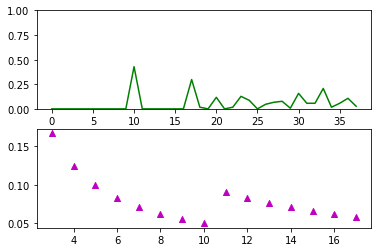

In [37]:
# PC1 - more common event

# Show probs for each epoch
def print_KSE(ensemble,Ne=None,do_probs=True):
    if do_probs:
        prob_ts = InfoGain.bound(np.mean(ensemble,axis=0),Ne=Ne)
        # pdb.set_trace()
        fig,axes = plt.subplots(ncols=1,nrows=2)
        axes.flat[0].plot(prob_ts,color='g')
        axes.flat[0].set_ylim([0,1])
    N_epochs = np.arange(3,22,1)
    KSE = dict()
    for N_epoch in N_epochs:
        KSE[N_epoch] = get_KSE(N_epoch=N_epoch,
                        ensemble=ensemble,debug=0)    
    
        #print(f"KSE for {N_epoch} epochs:"
        #          f"{KSE[N_epoch]:0.3f}")
        axes.flat[1].scatter(N_epoch,KSE[N_epoch],
                        marker="^",c="m")
    axes.flat[1].set_ylim([0,max(KSE.values())])
    
# raw_fcst = FCST[rho][tweak_max]
Ne_sub = 100
fcst_pw = subsample(FCST_PW[166.09][1e-6][99.5][400][:,::400],Ne=Ne_sub)
print_KSE(fcst_pw,Ne=Ne_sub)
# DO DIFFERENCE PLOTS LIKE WILLIAMS BOOK

The upper plot shows the raw probabilities (unbounded?). The lower plot shows H_{KS} as a function of epoch length $N_\alpha$: it appears to converge to $\sim 0.25$ bits per epoch. In other (abstract) terms, the system is generating uncertainty at a rate of a coin-flip's worth every four output times. But of course the average (which $H_{KS}$ measures) hides the intermittency of this information loss (which is tied up in the poorly forecast occurence of rare events). Let's compute $H_{KS}$ for the rarer event.

In [24]:
np.mean(fcst_pw,axis=0)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.05 , 0.01 , 0.06 , 0.02 , 0.01 ,
       0.085, 0.015, 0.08 , 0.05 , 0.02 , 0.07 , 0.06 , 0.045, 0.045,
       0.015, 0.065])

From the upper panel, we see this event is indeed much rarer. However, the bottom panel suggests information loss is similar to the more common event, in the limit of $N_\alpha$. This is because the system generating the time series is the same.

Now, let's recompute a "good" and "bad" ensemble, this time running L63 in a more intermittent regime:

In [19]:
rho = 166.1

_TRUTHS, _ENSEMBLES = generate_all_L63(x0,y0,z0,rho,cutoff,nt_all,
                            chunksize,pcs,plot_both=True,
                            title=f"x0,y0,z0 as {x0}",tweak_max=tweak_max)

TRUTHS.update(_TRUTHS)
ENSEMBLES.update(_ENSEMBLES)


NameError: name 'generate_all_L63' is not defined

In [ ]:
print_KSE(ENSEMBLES[rho][pcs[0]])


In [ ]:
print_KSE(ENSEMBLES[rho][pcs[1]])

Again, despite different probability time series, the value of $H_{KS}$ converges to a similar value. With a smaller value of $N_\alpha$, the value of $H_{KS}$ is more sensitive to individual events. The forecaster is likely more interested in short periods of large surprise rather than the average surprise of common events, so averaging hides the real-world impact.

The reason why the more predictable situation has a higher H_KS at the start is because you are more likely to hit a bad forecast (close to 0.5, max entropy). For the less predictable situation, you need a longer time series to demonstrate larger surprise. Eventually it converges to the same value because it's the same system, despite reducing to a binary (percentile exceedence).

Now we have estimated prior uncertainty, let's evaluate the two EFS forecasts for each regime (less and more intermittent), using the unperturbed L63 runs as observed "truth" with no error. Note we bound forecast probabilites

In [ ]:
# Seed random generator for repeatability!
# np.random.seed(1)
def get_thresh(Ne):
    thresh = (1/(3*Ne))
    return thresh

def bound_low(prob,limit=0.0001):
    return max(limit,prob)

def bound_high(prob,limit=0.9999):
    return min(limit,prob)

def bound(prob):
    if prob < 0.5:
        return bound_low(prob)
    else:
        return bound_high(prob)

def bound_ensemble(probs,Ne):
    thresh = get_thresh(Ne)
    probs[probs<thresh] = thresh
    probs[probs>(1-thresh)] = 1-thresh
    return probs
    
def remove_nans(val):
    if isinstance(val,np.ndarray):
        val[np.isnan(val)] = 0
        val[val == -np.inf] = 0
        val[val == -np.inf] = 0
    elif isinstance(val,float):
        if np.isnan(val) or val==np.inf or val==-np.inf:
            val = 0
    return val


In [ ]:
# Cross entropy - find in info gain script

# Maybe work out BS to compare the reward of rare events - histogram of scores per epoch?

def compute_DKL(f,o,):
    rn = remove_nans
    DKL = rn((1-o)*np.log2((1-o)/(1-f))) + rn(o*np.log2(o/f))
    #pdb.set_trace()
    return remove_nans(DKL)

def compute_DSC(nk,ok,o):
    ok = remove_nans(ok)
    p_y = nk/np.sum(nk)
    p_o = np.mean(o)
    # dsc_all = p_y * ((ok * np.log2(ok/o)) + ((1-ok) * np.log2((1-ok)/(1-o)))) 
    dsc_all = p_y * (remove_nans(ok * np.log2(ok/p_o)) + 
                        remove_nans((1-ok) * np.log2((1-ok)/(1-p_o))) ) 
    # val_allk = nk*( (ok * np.log2(ok/o)) + ( (1-ok) * np.log2((1-ok)/(1-o)) ) )
    # val = np.nansum(val_allk)/np.nansum(nk)
    # val = np.sum(val_allk)/np.sum(nk)
    return np.sum(dsc_all)

def compute_REL(nk,ok,fk):
    """
    nk is number of forecasts in this prob bin, 2D
    ok_arr has value of o-bar for each prob bin: 2D
    fk_arr has prob value for each bin: 2D
    likewise, iok and ifk are for the not-observed values.
    """
    ok = remove_nans(ok) 
    p_y = nk/np.sum(nk)
    rel_all = p_y * (
        remove_nans(ok * np.log2(ok/fk)) + 
        remove_nans((1-ok) * np.log2((1-ok)/(1-fk))) ) 
    return np.sum(rel_all)
    # return remove_nans(val)

def compute_UNC(o):
    p_o = np.mean(o)
    unc = -p_o*np.log2(p_o) - (1-p_o)*np.log2(1-p_o)
    return unc 
    
def compute_skill_score(unc,dkl=None,rel=None,dsc=None):
    if dkl is None:
        pass
    else:
        val = (np.mean(dkl)-unc)/(0-unc)
    return val
    
def S_per_epoch():
    # Surprise per epoch
    # Can ignore penalty for non-unity prob of correct negatives
    
    # if ob = 0
    # only punish for false alarm component
    
    # if ob = 1
    # punish for missed hit and correct positive error
    
    pass
    
# want to plot and compute per epoch (like object based)
# and also for the whole period. And discuss skill score. 
# The choice of UNC could be set depending on the inherent unc.

# reorganise so there is a clear collection of ensembles/truth

# then can vary different things and show the results below
# 20 v 40 ensemble members
# two regimes of L63 and different percentiles
# window length (chunk size) -> rename to window?
# dt of L63


def get_fk(Ne):
    pp = np.linspace(0,1,Ne+1)
    fk = bound_ensemble(pp,Ne) 
    return fk
        
def compute_surprise(f,o,fk):
    nk = np.zeros_like(fk)
    ok = np.zeros_like(fk)
    DKL = np.ones(N_epoch)
    oc = 0
    for epoch in np.arange(N_epoch):
        pbin_idx = np.where(fk==f[epoch])[0][0]
        nk[pbin_idx] += 1
        ok[pbin_idx] += o[epoch]
        oc += o[epoch]
        DKL[epoch] = compute_DKL(f[epoch],o[epoch])
    return DKL, nk, ok,oc
    
def compute_o_freq(f,o,fk,N_epoch):
    oo = o.flatten()
    ff = f.flatten()
    nk = np.zeros_like(fk)
    ok = np.zeros_like(fk)

    for kidx,k in enumerate(fk):
        kwhere = np.where(ff==k)
        nk[kidx] = kwhere[0].shape[0]
        o_ct = oo[kwhere]
        ok[kidx] = np.sum(o_ct)/N_epoch
    return nk, ok
    
def do_verif_suite(f,o,fk,N_epoch,DKL_only=False):
    DKL = compute_DKL(f,o)
    if DKL_only:
        return DKL
    UNC = compute_UNC(o)
    nk,ok = compute_o_freq(f,o,fk,N_epoch)
    DSC = compute_DSC(nk,ok,o)
    REL = compute_REL(nk,ok,fk)
    # SS = compute_skill_score(dsc=DSC,rel=REL,unc=UNC)
    SS = compute_skill_score(unc=UNC,dkl=DKL)
    return DSC, REL, UNC, DKL, SS

In [ ]:
rhos = (166.08,166.1)

def do_DKL(ens,rhos,pcs,subsample=None):
    N_epoch = 20
    # Get probs for all ensembles
    # pcs = [91.0,99.5]
    Ne = ens[rhos[0]][pcs[0]].shape[0]
    if subsample is not None:
        Ne = int(subsample * Ne)
    PROBS = {rho:{pc:-1*np.ones([N_epoch]) for pc in pcs} 
                 for rho in rhos}
    DKL = {rho:{pc:0 for pc in pcs}for rho in rhos}
    DSC = {rho:{pc:0 for pc in pcs}for rho in rhos}
    REL = {rho:{pc:0 for pc in pcs}for rho in rhos}
    UNC = {rho:{pc:0 for pc in pcs}for rho in rhos}
    SS = {rho:{pc:0 for pc in pcs}for rho in rhos}
    for rho, pc in itertools.product(rhos,pcs):
        PROBS[rho][pc] = np.mean(ens[rho][pc][:Ne,:],axis=0)
        f = bound_ensemble(PROBS[rho][pc],Ne)
        fk = get_fk(Ne)
        # nk = get_nk()
        o = TRUTHS[rho][pc].astype(int)
        returns = do_verif_suite(f,o,fk,N_epoch)
        DSC[rho][pc] = returns[0]
        REL[rho][pc] = returns[1]
        UNC[rho][pc] = returns[2]
        DKL[rho][pc] = returns[3]
        SS[rho][pc] = returns[4]

    return DSC, REL, UNC, DKL, SS

DSC,REL,UNC,DKL,SS = do_DKL(ENSEMBLES,rhos = [166.08,166.1],pcs=pcs)

In [ ]:
print(DSC)
print(REL)
print(UNC)
print(DKL)
print(SS)

Explain experiments:

In [ ]:
# test
%pdb off
def plot_bars(DKL,rhos,pcs,N_epoch=20):
    def do_bar(ax,DKL,rho,pc,c,N_epoch,side,width=0.6):
        if side == 'left':
            wd = -width/2
        else:
            wd = width/2
        xx = np.arange(N_epoch+1) + wd
        ax.bar(xx,DKL[rho][pc],wd,
                label=f"rho = {rho:.2f}, pc = {pc:.1f}",color=c)
        ax.hlines(xmin=0,xmax=N_epoch,y=np.mean(DKL[rho][pc]),color=c)
        return ax

    fig,axes = plt.subplots(ncols=1,nrows=len(rhos),
                                figsize=(10,5*len(rhos)))
    cols = iter(['r','m','g','b'])
    nt = nt_all - cutoff

    for rho, pc in itertools.product(rhos,pcs):
        c = next(cols)
        if len(rhos) == 1:
            ax = axes
        elif rho == rhos[0]:
            ax = axes.flat[0]
        elif rho == rhos[1]:
            ax = axes.flat[1]

        if pc == pcs[0]:
            side = 'left'
        else:
            side = 'right'
        ax = do_bar(ax,DKL,rho,pc,c,N_epoch,side)
    
    if len(rhos) == 1:
        axes.legend()
    else:
        for nrho in range(len(rhos)):
            axes.flat[nrho].legend()
    return

In [ ]:
plot_bars(DKL,rhos,pcs)

In [ ]:
bDSC,bREL,bUNC,bDKL,bSS = do_DKL(bad_ENSEMBLES,rhos = [166.08,],pcs=pcs)
print(bDSC)
print(bREL)
print(bUNC)
print(bDKL)
print(bSS)



In [ ]:
plot_bars(bDKL,[166.08,],pcs=pcs)

In [ ]:
# Run an ensemble with third of the members 
rho = 166.08
# Ne_half = int(Ne/3)
# dkl_half = {q:{rho:{pc:0 for pc in pcs}for rho in rhos} for
#                 q in ("good","bad")}

# for ENS, q in zip((ENSEMBLES,bad_ENSEMBLES),("good","bad")):
#     bDSC,bREL,bUNC,bDKL,bSS = do_DKL(bad_ENSEMBLES,rhos = [166.08,],pcs)

    
    #for pc in pcs:
    #    p_half = np.mean(ENS[rho][pc][:Ne_half,:],axis=0)
    #    f_half = bound_ensemble(p_half,Ne_half)
    #    fk_half = get_fk(Ne_half)
        # nk = get_nk()
    #    o = TRUTHS[rho][pc].astype(int)
    #    _1, _2, _3, dkl_half[q][rho][pc], _4 = do_verif_suite(
    #                f_half,o,fk_half)
    
sDSC,sREL,sUNC,sDKL,sSS = do_DKL(ENSEMBLES,
                        rhos = [166.08,],pcs=pcs,subsample=0.33)
  
    
print(sDSC)
print(sREL)
print(sUNC)
print(sDKL)
print(sSS)
plot_bars(sDKL,[rho,],pcs)

In [ ]:
sbDSC,sbREL,sbUNC,sbDKL,sbSS = do_DKL(bad_ENSEMBLES,
                        rhos = [166.08,],pcs=pcs,subsample=0.33)    
    
print(sbDSC)
print(sbREL)
print(sbUNC)
print(sbDKL)
print(sbSS)
plot_bars(sbDKL,[rho,],pcs)

In [ ]:
print("\U0001F923")



### 1) Thunderstorms, 3km, 100 members
Intuitively, the end-user should act when $\mathrm{P_f}(\xi) > \frac{C(\xi)}{L(\xi)}$, if the model is reliable (good assumption?), and assuming we only want to prevent a mean loss over a long time period. The change in skill of the model is the remaining cross-entropy in the forecast:

$$ H_\times = D_{KL} + H \\
            = RES_f -+? REL_f + UNC_f + H(o) $$

where we assume that doubling the ensemble members only improves the REL and degrades the RES (though this isn't always the case, like AI paper about compression). We would like to know how much better the reliability must be (normalised by the cost per ...).

Again, intuitively, the probabilities make a bigger difference to Cath, as the loss accrued by not mitigating a hazard is much smaller for Igor. Further, thunderstorms are uncommon, meaning that average surprise is low (it is usually safe to assume there are no thunderstorms), but the event surprise is high.

(Do we need more ensemble members with a higher resolution? Can we show that in maths?)

There is also the problem that, if an event is too rare, that it will not be sampled by the ensemble, leading to a catastrophic failure. Bounding the minimum probability (e.g., 1%) is a safeguard, but intractable to the end user for very rare events (it would either be interpreted as 0%, or C/L would be higher than the hazard frequency, leading to a net loss). This shows why forecasts should not be issued beyond an information horizon - this asymptotes, therefore a tolerance must be introduced whereby returns have diminished compared to the cost of running to that time. This is related to CC, but also for rarer events, because the small skill is multiplied by value, and also by rarity of the event. When time becomes involved, we need the K-S entropy. (A rarer event has more entropy. Also, a smaller spatial scale has lower predictability and faster error growth, and more information is needed per square km (?), but show as percent of ignorance removed, or absolute information gained in bits.)

Can we show info gain per unit resource? Or how much the REL v RES must improve to decide how to spend the resources. Information is equally as useful, so we only have to show how good the improvement must be, though comment on the value schematic whereby diminishing returns are also far more valuable because of the high surprise (but most of the time this is wasted due to low average entropy). It's why false alarms are not as important, so maybe RES is more important than REL? Bias is welcome? Kernel dressing could be an asymmetric beta function towards the value?

Improvements in reliability is more valuable the rarer the event and lower the cost-loss ratio? IG is bits, and each bit is equal, but information can be multiplied by value, hence RES v REL improvements have different value.

Inherent uncertainty cancels:

$$ \Delta H_\times = \Delta RES \Delta REL \\
= I(o{;}f) and what...
$$

Could normalise the change is Hx by unit resource and value?

Would need more ensemble members with finer resolution depending on the forecast lead time of interest? Error growth rates are "adjoint-like" at first, but growth exponentially (where REL becomes progressively more important than RES). If we have finer grid, more information is acquired (dt also increases due to CFL), but error growth is faster because of that.

Rarer event has more self-entropy and hence needs more information for the event, but less for the average over a period. Show penalties:

2x2 matrix of info gain required and the max require, or res v rel value? Info gain per unit resource, as function of configuration, enduser, and flow pattern?

FSS is like reducing the partition - 
like increasing resolution...KS -> asymptotes. 
could you estimate where to stop increasing grid res?!
Then dp is the accuracy of estimating risk

Frigg LSE KSE paper is amazing!

Now we have a TRUTH, which is not known. This is discretised
with error into chunks identical to the forecast chunks
to represent similar errors. Not sure if that is correct but ah 

Verify for Hx
Value of system improvement = Is there diminishing returns situation
for improving one or the other, per unit resource (log tail-off wrt. improvements),
though skill score is additive (can say skill score because the 
observation "climo" is the same for both model).

should be time dimension?
dbool = np.diff(results,axis=0)
This is -1, 0 (0), 0 (1), +1 showing change between states. There is a
correlation in the time dimension but not membership.
There is more value in +1 than -1 #
there is more value than no-change (1) than no-change (0) (entropy of event diff?)
Would you like to increase information entropy now or in future? Have to spend
value - do you want more information sooner or less info later (but more valuable)?
Want to reduce entropy of rare events v dataset entropy? 
->Missed hit worse than false alarm
However, how to assess this is probabilities? It's the REL value in Hx.

Punishment of  

REL is the skill of change matrix (punishment in transition for decision tree)
RES is the skill of probs per epoch

What do we need from this?

How does KSE change if the same time period is simulated with
a higher dt, or "windowing"/chunking? Like error growth being 
faster at smaller scales?

Now to show how Hx of models changes with the variables. How does KSE relate to "Bayesian prior" to reduce ignorance as much as possible?

Conclusions here

Future work:

* How to best extract information at the $\Delta x$-scale, such as
- Machine Learning
- Feature identification
* 



Some definitions:

| Symbol| Meaning |
| ------ | ------- |
| $N_e$    | Ensemble membership |
| $N_\alpha$ | Number of "atoms" or "unit time steps" |
| $\tau$ | Total time (sec) |
| $H$ | Average entropy or surprise |
| $H_I$ | Self-information or event surprise (bits) |
| $H_\times$ | Cross-entropy (bits) |
| $\textrm{IG}$ | Information gain (bits) |
| $\xi$ | Hazard of interest |
| $\textrm{CC}$ | Channel capacity |
| $I(x{;}y)$ | Mutual information between $x$ and $y$ |
| $$~D_{KL}(x\|y)$$ | Kullback-Liebler Divergence between $x$ and $y$ |
| $\Delta x$ | Spatial granulatisation (i.e., horizontal grid-spacing)| 
| $\Delta p$ | Probability granularisation (i.e., $N_e^{-1})$|
| $\mathrm{P}(\xi)$ | (General) probability of event $\xi$ |
| $\mathrm{P_f}(\xi)$ | Forecasted probability of event $\xi$ |
| $\mathrm{P_o}(\xi)$ | Frequency of observed event $\xi$ |
| $\mathbb{W}$ | Set of all messages |
| $W$ | One original message |
| $\hat{W}$ | One corrupted message |
| $\frac{C}{L}$ | Cost--loss ratio |
| $p_{crit}$ | Risk tolerance |
| $\varsigma(W)$ | Surprise reduction operation of message $W$ |
| REL | Reliability of the weather model in question (curly m)|
| RES | Discrimination (or Brier-type resolution) |

Selected mathematical symbols:

| Symbol| Meaning |
| ------ | ------- |
| $\in$   | Belonging to the set of |
